### Описание задачи

Цель - спрогнозировать отток клиентов оператора связи «Ниединогоразрыва.ком».
Поттенциально отточным клиентам будут предложены промокоды и спец условия для их удержания.

Оператор предоставляет следующие услуги:
- Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).
- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных
Данные состоят из файлов, полученных из разных источников:
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

 ### План решения задачи. 
    
- Загрузим и проанализируем данные - посмотрим на их структуру, аномалии, пропуски, дубликаты, распределение
- Подготовим данные для работы с машинным обучением - объединим в один датасет, почистим лишнее, закодируем. Разделим на обучающую, вализационную и тестовую выборки в соотношении 50%, 25% и 25%
- Применим три модели: логистическую регрессию, RandomForest и CatBoost
- Подберем гиперпараменты, посмотрим результаты на валидационной выборке и проверим работу лучшей модели на тестовой
- Проанализируем результаты: выведем матрицу ошибок и важность признаков. Оценим, насколько модель применима для бизнес-решений

### Предобработка и анализ данных

Исследуем каждый файл данных в отдельности: посмотрим на данные, на их объем, уникальность, типы, дубликаты, распределение и структуру

In [1]:
#pip install catboost

In [2]:
# Подключим библиотеки
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline


In [3]:
#Загрузим данные
try:
    contracts = pd.read_csv('final_provider/contract.csv')
    clients = pd.read_csv('final_provider/personal.csv')
    inet_services = pd.read_csv('final_provider/internet.csv')
    phone_services = pd.read_csv('final_provider/phone.csv')

except:
    contracts = pd.read_csv('/datasets/final_provider/contract.csv')
    clients = pd.read_csv('/datasets/final_provider/personal.csv')
    inet_services = pd.read_csv('/datasets/final_provider/internet.csv')
    phone_services = pd.read_csv('/datasets/final_provider/phone.csv')

In [4]:
#Посмотрим на данные
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
#посчитаем уникальных клиентов
print(len(pd.unique(contracts['customerID'])))

7043


In [7]:
#посчитаем дубликаты
contracts.duplicated().sum()

0

In [8]:
#Добавим столбец с непустой датой окончания контракта. Если контракт еще действует, поставим дату выгрузки - 1 февраля 2020
contracts['EndDate_Today'] = contracts['EndDate']
contracts.loc[contracts['EndDate']=='No', 'EndDate_Today'] = '2020-02-01'

In [9]:
#Преобразуем типы данных
contracts['TotalCharges'] = pd.to_numeric(contracts['TotalCharges'], errors='coerce')
contracts['BeginDate'] = pd.to_datetime(contracts['BeginDate'], format='%Y-%m-%d', errors='coerce')
contracts['EndDate_Today'] = pd.to_datetime(contracts['EndDate_Today'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')
contracts['EndDate'] = pd.to_datetime(contracts['EndDate'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

In [10]:
#Добавим признаки "потерянный клиент", "срок жизни клиента" и "год начала сотрудничества"
contracts['LifeTime'] = contracts['EndDate_Today']- (contracts['BeginDate'])
contracts['BeginYear'] = pd.DatetimeIndex(contracts['BeginDate']).year
contracts['Lost_client'] = 0
contracts.loc[contracts['EndDate'].isna()==True, 'Lost_client'] = 1

In [11]:
contracts['LifeTime'] = contracts['LifeTime'].astype(int)

In [12]:
#Удалим лишние столбцы
contracts = contracts.drop(['EndDate','BeginDate','EndDate_Today'], axis = 1)

In [13]:
contracts.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LifeTime,BeginYear,Lost_client
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,2678400000000000,2020,1
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,89510400000000000,2017,1
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,5270400000000000,2019,0
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,118454400000000000,2016,1
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,5270400000000000,2019,0


In [14]:
#Посмотрим на баланс классов
print(contracts.groupby(by='Type')['Type'].count())
print()
print(contracts.groupby(by='PaperlessBilling')['PaperlessBilling'].count())
print()
print(contracts.groupby(by='PaymentMethod')['PaymentMethod'].count())
print()
print(contracts.groupby(by='Lost_client')['Lost_client'].count())

Type
Month-to-month    3875
One year          1473
Two year          1695
Name: Type, dtype: int64

PaperlessBilling
No     2872
Yes    4171
Name: PaperlessBilling, dtype: int64

PaymentMethod
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Electronic check             2365
Mailed check                 1612
Name: PaymentMethod, dtype: int64

Lost_client
0    1869
1    5174
Name: Lost_client, dtype: int64


In [15]:
#Посмотрим на распределение данных
contracts.describe()

,MonthlyCharges,TotalCharges,LifeTime,BeginYear,Lost_client
count,7043.000000,7032.000000,7.043000e+03,7043.000000,7043.000000
mean,64.761692,2283.300441,8.519007e+16,2016.878603,0.734630
std,30.090047,2266.771362,6.459159e+16,1.970573,0.441561
min,18.250000,18.800000,0.000000e+00,2013.000000,0.000000
25%,35.500000,401.450000,2.358720e+16,2015.000000,0.000000
50%,70.350000,1397.475000,7.629120e+16,2017.000000,1.000000
75%,89.850000,3794.737500,1.448064e+17,2019.000000,1.000000
max,118.750000,8684.800000,1.893024e+17,2020.000000,1.000000


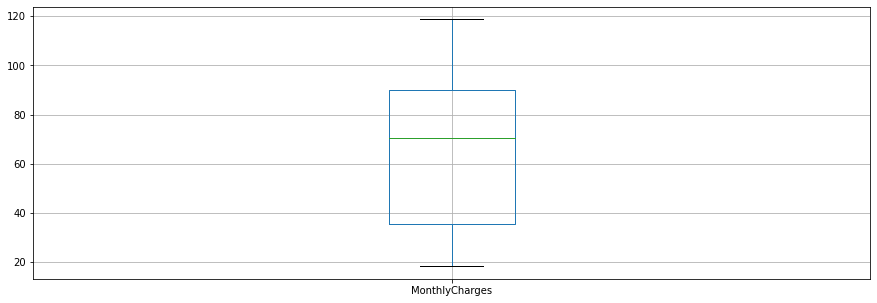

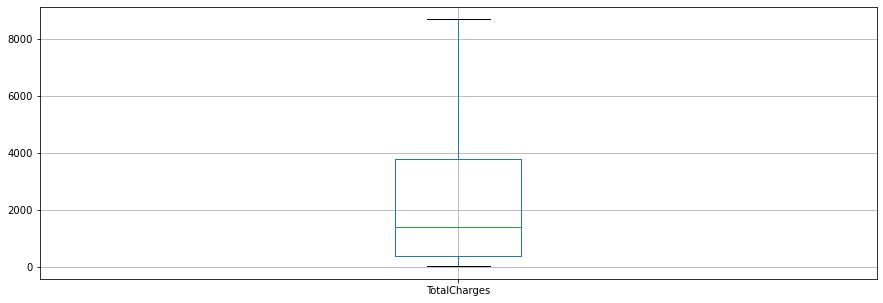

In [16]:
contracts.boxplot(column=['MonthlyCharges'],figsize=(15, 5))
plt.show()
contracts.boxplot(column=['TotalCharges'],figsize=(15, 5))
plt.show()

not numeric type customerID
not numeric type Type
not numeric type PaperlessBilling
not numeric type PaymentMethod


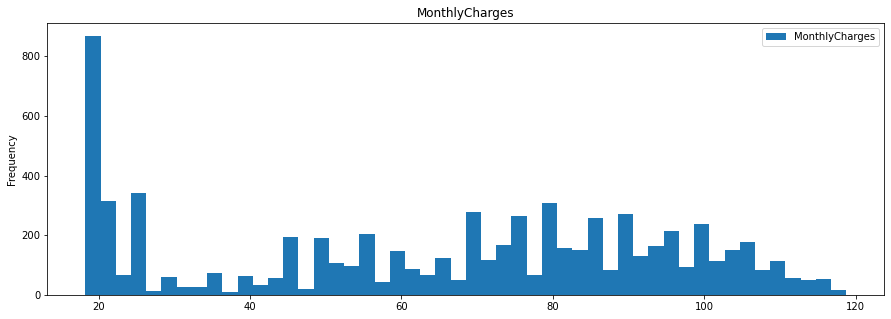

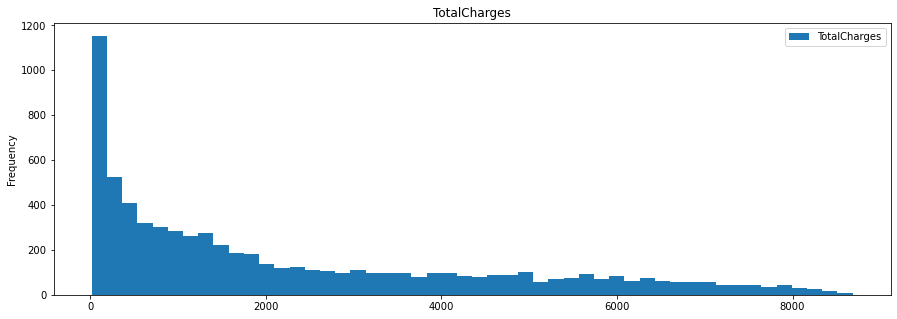

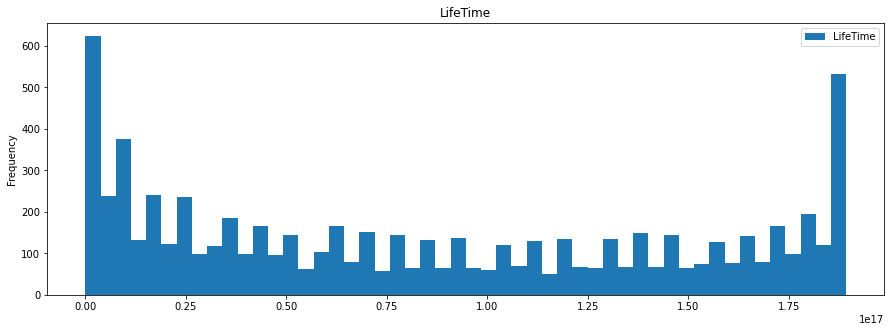

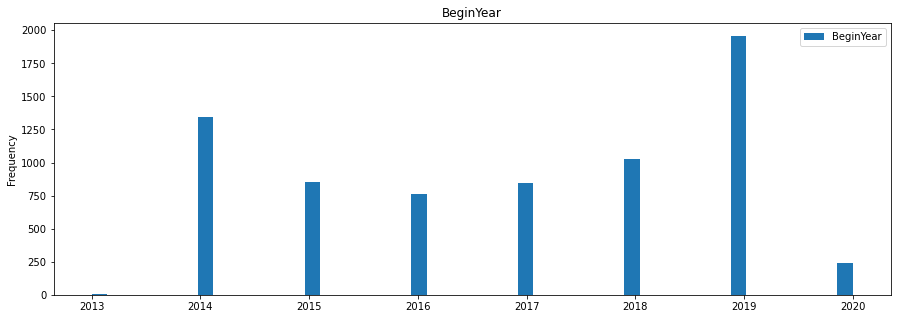

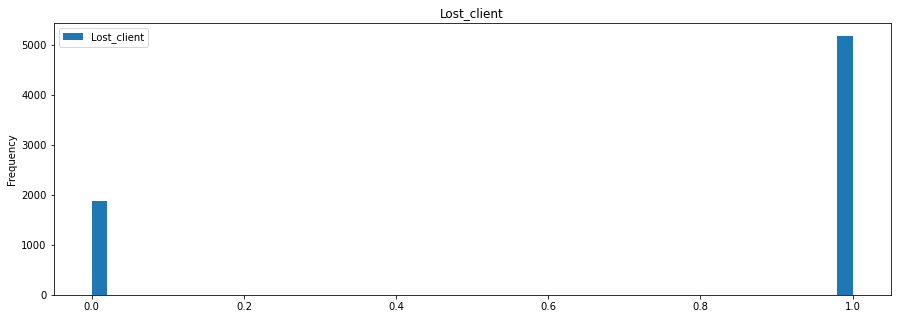

In [17]:
for i in contracts:
    try:
        contracts.plot(y = i,title = i,kind = 'hist', bins = 50,figsize=(15, 5))
    except:
        print('not numeric type',i)

<AxesSubplot:title={'center':'MonthlyCharges<22'}, ylabel='Frequency'>

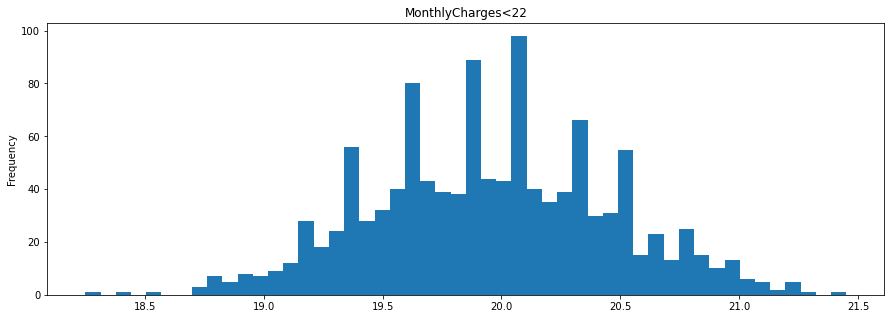

In [18]:
#посмотрим внимательней на структуру пика околонулевых платежей
contracts['MonthlyCharges'].loc[contracts['MonthlyCharges']<22].plot(title = 'MonthlyCharges<22',kind = 'hist', bins = 50,figsize=(15, 5))

Выводы по данным  о договорах:
- Представлена информация по 7 тыс. контрактов уникальных клиентов. 73% записей - ушедшие клиенты
- 1,2 тыс клиентов (17%) заплатили оператору около 20 евро - видимо, это самый популярный и дешевый тариф.
- 55% клиентов предпочитают ежемесячную оплату. Четверть - заключили контракт сразу на 2 года.
- 59% клинтов не запрашивают чеки об оплате.
- 34% пользователей оплачивают электронными чеками. 44% - автоматическими банковскими транзакциями (картой или переводом), 23% - через Mailed check
- Средний месячный доход от клиента - 65 евро, минимальный - 18 евро, медиана - 70 евро, а максимальный - 119 евро
- Общие доходы от клиента варьируются от 19 евро за весь период до 8685 уе с медианой в 1395 евро
- Средняя продолжительность жизни клиента - 986 дней (почти 3 года), медиана - 883 дня (2,5 года). Самый лояльный клиент - провел с оператором целых 6 лет

In [19]:
clients.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [20]:
#посчитаем уникальных клиентов
print(len(pd.unique(clients['customerID'])))

7043


In [21]:
#посчитаем дубликаты
clients.duplicated().sum()

0

In [22]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [23]:
#Посмотрим на баланс классов
print(clients.groupby(by='gender')['gender'].count())
print()
print(clients.groupby(by='SeniorCitizen')['SeniorCitizen'].count())
print()
print(clients.groupby(by='Partner')['Partner'].count())
print()
print(clients.groupby(by='Dependents')['Dependents'].count())

gender
Female    3488
Male      3555
Name: gender, dtype: int64

SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Partner
No     3641
Yes    3402
Name: Partner, dtype: int64

Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64


Выводы по данным  о клиентах:
- Представлена информация по 7 тыс. уникальных клиентов, все данные - текстовые
- Равное распределение по гендерному признаку (50% мужчин и женщин)
- 16% клиентов - пенсионеры
- 52% клиентов имеют партнера, 30% - иждевенцев (вероятно, дети)

In [24]:
inet_services.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [25]:
#посчитаем дубликаты
inet_services.duplicated().sum()

0

In [26]:
inet_services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [27]:
for i in inet_services:
    if i not in 'customerID':
        print(inet_services.groupby(by=i)[i].count())
        print()

InternetService
DSL            2421
Fiber optic    3096
Name: InternetService, dtype: int64

OnlineSecurity
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

OnlineBackup
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

DeviceProtection
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

TechSupport
No     3473
Yes    2044
Name: TechSupport, dtype: int64

StreamingTV
No     2810
Yes    2707
Name: StreamingTV, dtype: int64

StreamingMovies
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64



Выводы по данным об интернет-сервисах:
- Представлена информация по 5,5 тыс. уникальных клиентов, все данные - текстовые
- Подключение к интернету через оптоволокно у 56% пользователей, 44% - через телефонную сеть DSL
- Блокировкой небезопасных сайтов пользуются 37% клиентов, антивирусом - 44%
- Облачное хранилище используют 44% пользователей
- Выделенная линия техподдержки есть у 37% абонентов
- Стриминговое ТВ и каталог фильмов смотрят 49% и 50% клиентов

In [28]:
phone_services.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [29]:
#посчитаем дубликаты
phone_services.duplicated().sum()

0

In [30]:
phone_services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [31]:
print(phone_services.groupby(by='MultipleLines')['MultipleLines'].count())

MultipleLines
No     3390
Yes    2971
Name: MultipleLines, dtype: int64


Выводы по данным о телефонных-сервисах:
- Представлена информация по 6,4 тыс. уникальных клиентов, данные - текстовые
- 47% пользователей подключили телефон к нескольким линиям одновременно 

### Объединение данных и подготовка к использованию в моделях

Объединим данные по customerID и обработаем образовавшиеся пропуски. Удалим лишние столбцы. 


Дополнительно - закодируем текстовые столбцы методом ОНЕ. 
В результате получим два варианта данных для моделей - с кодированием и без.

In [32]:
data = contracts.merge(clients, on='customerID', how='outer')
data = data.merge(inet_services, on='customerID', how='outer')
data = data.merge(phone_services, on='customerID', how='outer')
data.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LifeTime,BeginYear,Lost_client,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,2678400000000000,2020,1,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,89510400000000000,2017,1,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,5270400000000000,2019,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,118454400000000000,2016,1,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,5270400000000000,2019,0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [33]:
#Обработаем пропуски после объединения
data['MultipleLines'] = data['MultipleLines'].fillna('No')

data['InternetService'] = data['InternetService'].fillna('No')
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('No')
data['OnlineBackup'] = data['OnlineBackup'].fillna('No')
data['DeviceProtection'] = data['DeviceProtection'].fillna('No')
data['TechSupport'] = data['TechSupport'].fillna('No')
data['StreamingTV'] = data['StreamingTV'].fillna('No')
data['StreamingMovies'] = data['StreamingMovies'].fillna('No')

data['StreamingMovies'] = data['StreamingMovies'].fillna('No')

data = data.dropna(subset=['TotalCharges'])

In [34]:
#Удалим лишние столбцы
data = data.drop(['customerID'], axis = 1)

In [35]:
data.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
LifeTime            0
BeginYear           0
Lost_client         0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [36]:
#Разделим данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    data.drop(['Lost_client'],axis = 1), data['Lost_client'], test_size=0.25, random_state=261222)

In [37]:
#Зададим категориальные и количественные признаки
numeric = ['MonthlyCharges','TotalCharges','LifeTime','BeginYear','SeniorCitizen']
categorical = ['OnlineSecurity', 'PaperlessBilling', 'PaymentMethod', 'Type', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [38]:
#Нормальзуем количественные данные и закодируем категориальные техникой ОНЕ для использования в линейной регрессии
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

features_train_scaled = scaler.fit_transform(features_train[numeric])
features_train_ohe = encoder.fit_transform(features_train[categorical])
features_train_tramsformed = pd.concat([pd.DataFrame(features_train_scaled, columns=numeric),
                                    pd.DataFrame(features_train_ohe, columns=encoder.get_feature_names())], 
                                       axis=1)


features_test_scaled = scaler.transform(features_test[numeric])
features_test_ohe = encoder.transform(features_test[categorical])
features_test_tramsformed = pd.concat([pd.DataFrame(features_test_scaled, columns=numeric),
                                    pd.DataFrame(features_test_ohe, columns=encoder.get_feature_names())], 
                                      axis=1)

/Users/a.oleinik/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/a.oleinik/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
#Проверим, что с данными все ок
print(features_train_tramsformed.shape)
print(features_test_tramsformed.shape)
print(features_train_tramsformed.isna().sum())

(5274, 23)
(1758, 23)
MonthlyCharges                0
TotalCharges                  0
LifeTime                      0
BeginYear                     0
SeniorCitizen                 0
x0_Yes                        0
x1_Yes                        0
x2_Credit card (automatic)    0
x2_Electronic check           0
x2_Mailed check               0
x3_One year                   0
x3_Two year                   0
x4_Male                       0
x5_Yes                        0
x6_Yes                        0
x7_Fiber optic                0
x7_No                         0
x8_Yes                        0
x9_Yes                        0
x10_Yes                       0
x11_Yes                       0
x12_Yes                       0
x13_Yes                       0
dtype: int64


In [40]:
#Закодируем категориальные техникой Ordinal для использования в Randomforest
encoder = OrdinalEncoder()

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

features_train_oe[categorical] = encoder.fit_transform(features_train[categorical])
features_test_oe[categorical] = encoder.transform(features_test[categorical])

In [41]:
print(features_train_oe.shape)
print(features_test_oe.shape)
print(features_train_oe.isna().sum())

(5274, 19)
(1758, 19)
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
LifeTime            0
BeginYear           0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64


### Обучение моделей и подбор гиперпараметров

Вопрос с кросс-валидацией решим через использование GridSearchCV для подбора гиперпараметров.
Оценим работу каждой из моделей на обкучающей выборке.

In [42]:
#Подберем гиперпараметры для модели логистической регрессии
clf = LogisticRegression(random_state=261222, solver='liblinear')

parameters = { 'C': range (1, 10, 1) }
grid = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc')
grid.fit(features_train_tramsformed, target_train)
print(grid.best_params_)

{'C': 6}


In [43]:
#Лучший результат
print("best auc-roc is",round(grid.best_score_,2))

best auc-roc is 0.89


In [44]:
#Подберем гиперпараметры для модели RandomForest
clf = RandomForestClassifier(random_state=261222)

parameters = { 'n_estimators': range (100, 151, 10),
              'max_depth': range (1,13, 2) }
grid = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc')
grid.fit(features_train_oe, target_train)
print(grid.best_params_)

#Лучший результат
print("best auc-roc is",round(grid.best_score_,2))

{'max_depth': 11, 'n_estimators': 140}
best auc-roc is 0.89


In [45]:
%%time
clf = CatBoostClassifier(loss_function="Logloss", random_state=261222, cat_features=categorical, verbose=500)


parameters = {'depth': [5,7,9],
              'learning_rate': [0.02,0.03, 0.04],
              'iterations': [100, 200]}

grid = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc')
grid.fit(features_train, target_train)

0:	learn: 0.6842372	total: 59.8ms	remaining: 5.92s
99:	learn: 0.4026686	total: 187ms	remaining: 0us
0:	learn: 0.6852135	total: 1.72ms	remaining: 171ms
99:	learn: 0.4011988	total: 118ms	remaining: 0us
0:	learn: 0.6841379	total: 1.31ms	remaining: 130ms
99:	learn: 0.4023240	total: 114ms	remaining: 0us
0:	learn: 0.6841112	total: 1.25ms	remaining: 123ms
99:	learn: 0.3996777	total: 114ms	remaining: 0us
0:	learn: 0.6865008	total: 1.3ms	remaining: 128ms
99:	learn: 0.4004938	total: 116ms	remaining: 0us
0:	learn: 0.6798474	total: 1.28ms	remaining: 127ms
99:	learn: 0.3722364	total: 117ms	remaining: 0us
0:	learn: 0.6813045	total: 1.17ms	remaining: 116ms
99:	learn: 0.3750349	total: 123ms	remaining: 0us
0:	learn: 0.6796992	total: 1.34ms	remaining: 133ms
99:	learn: 0.3715048	total: 128ms	remaining: 0us
0:	learn: 0.6796594	total: 1.19ms	remaining: 118ms
99:	learn: 0.3733681	total: 115ms	remaining: 0us
0:	learn: 0.6832242	total: 1.3ms	remaining: 129ms
99:	learn: 0.3707494	total: 118ms	remaining: 0us
0:

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f85d65258e0>,
             param_grid={'depth': [5, 7, 9], 'iterations': [100, 200],
                         'learning_rate': [0.02, 0.03, 0.04]},
             scoring='roc_auc')

In [46]:
print(grid.best_params_)

#Лучший результат
print("best auc-roc is",round(grid.best_score_,2))

{'depth': 7, 'iterations': 200, 'learning_rate': 0.04}
best auc-roc is 0.91


Итого, после подбора гиперпараметров для LogisticRegression и RandomForestClassifier имеем следующие результаты:

- Аuc-roc для LogisticRegression с гиперпараметром С = 6 составил 0.89
- Аuc-roc для RandomForestClassifier с гиперпараметрами max_depth = 11, n_estimators = 140 составил 0.89
- Аuc-roc для CatBoostClassifier с гиперпараметрами depth = 7, iterations = 200, learning_rate = 0.04 составил 0.91
    
Далее протестируем работу CatBoostClassifier с гиперпараметрами depth = 7, iterations = 200, learning_rate = 0.04


### Тестирование модели

Проверим результаты работы модели на тестовой выборке

In [47]:
model = CatBoostClassifier(loss_function="Logloss", random_state=261222, cat_features=categorical, 
                           verbose=500, depth = 7, iterations = 200, learning_rate = 0.04)

model.fit(features_train, target_train)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print("auc-roc is ",round(roc_auc_score(target_test, probabilities_one_test),2))

0:	learn: 0.6634719	total: 5.28ms	remaining: 1.05s
199:	learn: 0.2744416	total: 749ms	remaining: 0us
auc-roc is  0.92


Целевое значение достигнуто. Посмотрим на матрицу ошибок

In [52]:
# Выведем матрицу ошибок
print(confusion_matrix(target_test,model.predict(features_test)))

[[ 312  177]
 [  58 1211]]


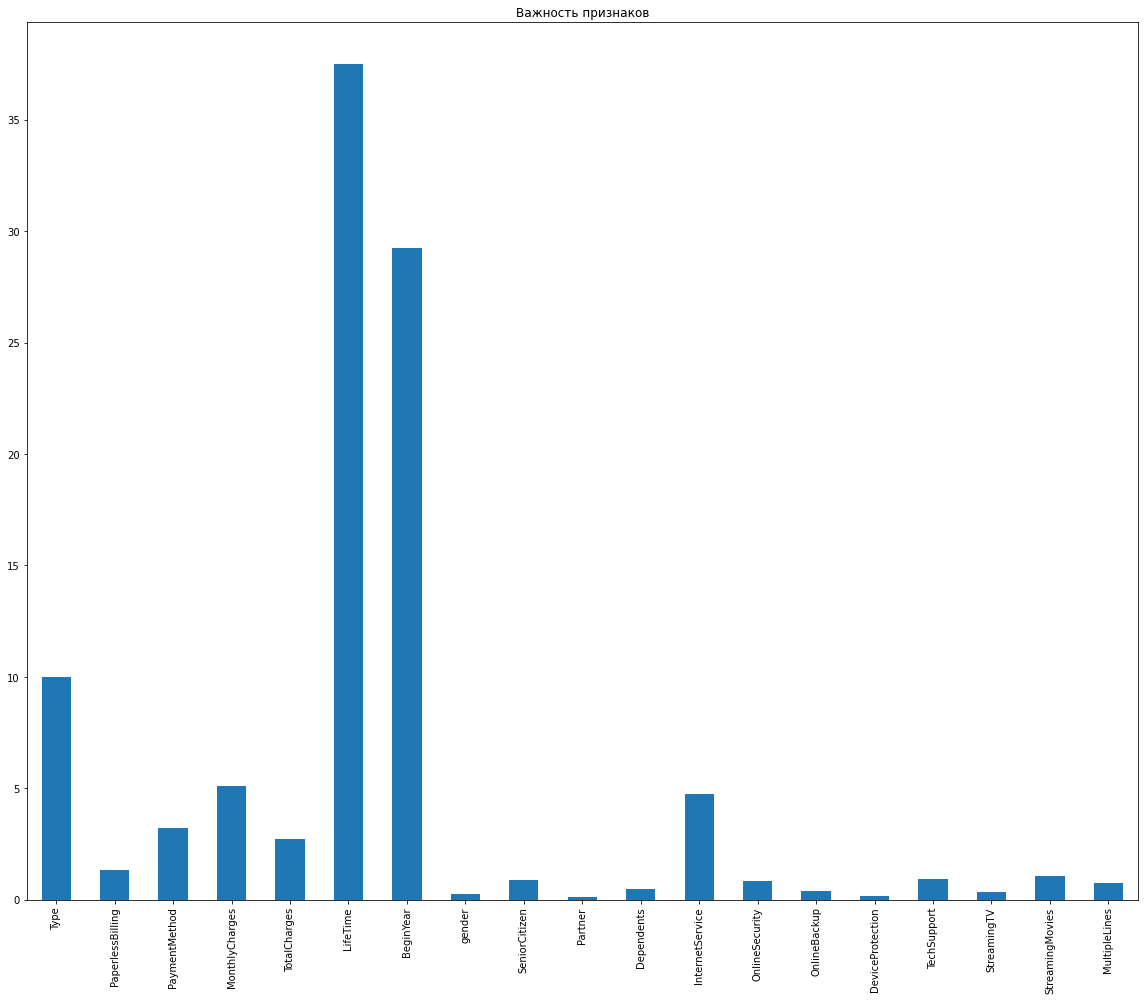

In [53]:
# Посмотрим на значимость признаков
imp = pd.Series(model.get_feature_importance(),
                         features_train.columns)
fig, ax = plt.subplots(figsize=(16,14))
imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

Модель верно распознала 87% клиентов. 
10% клиентов она приняла за уходящих, хотя на самом деле они не собирались расставаться с оператором.
3% клиентов ушли не замеченными моделью.

Наиболее значимые признаки - срок жизни клиента, год заключения контракта, тип контракта (оплата за год/ два или помесячно), сумма ежемесячных комиссий и наличие у клиента сервиса блокировки небезопасных сайтов.

Предлагаю запустить модель в работу и посмотреть на результаты в боевых условиях.

При использовании модели для удержания потенциально отточных клиентов следует заложить 10% погрешность в бюджете на скидки и без того лояльным клиентам.

3% уходящих клиентов не будут распознаны моделью. Взаимодействие с наиболее ценными и доходными следует вести через личные контакты, персональных менеджеров, интересующихся удовлетворенностью и планами клиентов.

### Финальный отчет

#### Статус по выполнению плана работы.
Изначально были запланированы следующие шаги:
- Загрузeка и анализ данных
- Подготовка данных для работы с машинным обучением. Разделение на обучающую, вализационную и тестовую выборки
- Применение 3 моделей: логистической регрессии, RandomForest и CatBoost
- Подбор гиперпараметров, проверка работы лучшей модели на тестовой выборке
- Анализ результатов. Оценка применимости модели для бизнес-решений


Из запланированного не выполнены шаги, связанные с валидационной выборкой. 
Применение GridSearchCV позволило определить не только значения гиперпараметров лучшей модели, но и значение целевой метрики roc-auc на кросс-валидации. Потребность в валидационной выборке пропала.
Датасет разделили на обучающую и тестовую выборки в соотношении 75% и 25%.

Прочие запланированные шаги исполнены

#### Возникшие трудности и инструменты их преодоления.

Основная трудность возникла с кодированием данных - три типа моделей потребовали три варианта представления данных:
- Случайный лес - Ordinal Encoder
- Линейная регрессия - One Hot Encoder 
(!) get_dummies не подходит для данного типа задач.
Дополнительно для линейных моделей требуется масштабирование количественных признаков.
- CatBoostClassifier не потребовал никакой дополнительной обработки.


Потенциально могли возникнуть проблемы из-за дисбаланса классов, но целевая метрика roc-auc невосприимчива к дисбалансу.

#### Ключевые шаги в решении задачи.
- Знакомство с задачей и целями бизнеса.
- Загрузка данных и понимание их качества - объем информации, проверка дублирования, заполнение пропусков, изменение типов, расчет новых переменных и исключение дублирующих метрик.
- Исследование данных - анализ распределения, выбросов и проч. Предварительные выводы по данным.
- Подготовка данных к моделированию - объединение датасетов, разделение на обучающую и тестовую выборки, кодирование категориальных и масштабирование количественных признаков. Для каждой модели потребовался свой тип обработки данных.
- Подбор гиперпараметров для моделей. Сравнение значений целевых метрик на кросс-валидации для трех моделей.
- Тестирование модели с лучшей целевой метрикой.
- Анализ матрицы ошибок и определение наиболее значимых признаков.
- Выводы и рекомендации для бизнеса.

#### Использованные признаки для обучения. Предобработка признаков.

Для обучения модели прогноза оттока использовалась следующая информация:
- о наличии у клиентов того или иного продукта, 
- о типе контракта, 
- о сроке жизни клиента, 
- о сумме комиссий и методе оплаты услуг,
- социально-демографические данные


Категориальные признаки были закодированы методами One Hot Encoder и Ordinal Encoder, количественные - масштабированы для линейной регрессии.

#### Итоговая модель, ее гиперпараметы и качество.

Лучший результат показала модель CatBoostClassifier с гиперпараметрами depth = 7, iterations = 200, learning_rate = 0.04

Значение метрики auc-roc на обучающей и тестовой выборках равно 0,91 и 0,92 соответственно.

Модель верно распознала 87% клиентов. 
10% клиентов она приняла за уходящих ошибочно. 3% ушедших клиентов модель не заметила.